In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [24]:
# get list of top 20 recommended products by user
rec_list = pd.read_csv('top20_products_recom.csv')

# get each user's actual cart
path = '/Users/Jeff/Documents/Insight/Data'
order_products__train = pd.read_csv(path+'/instacart_2017_05_01/order_products__train.csv')
orders = pd.read_csv(path+'/instacart_2017_05_01/orders.csv') #need order data to join user_id to order_products__train

### Plan:
1. For each of the train users, check their most recent cart, and see how many of the top X recommended items are in it.
2. Divide that number by X, to get a fraction by user. Then plot distn and average.

In [26]:
# Join user_id to order_id
order_products__train = order_products__train.merge(orders[['order_id','user_id']],on='order_id')
display(order_products__train.head())
orders.loc[orders['order_id']==1] #check that join works (i.e., this should be associated with user_id 112108)

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0


In [19]:
rec_list.drop(['Unnamed: 0'],axis=1,inplace=True)
rec_list.head()

,product_id,product_name,organic,freq_rank,user_id,rec_rank
0,13176,Bag of Organic Bananas,1,2,1,1
1,21137,Organic Strawberries,1,3,1,2
2,24852,Banana,0,1,1,3
3,21903,Organic Baby Spinach,1,4,1,4
4,39275,Organic Blueberries,1,11,1,5


In [9]:
#How many users will we validate on?
len(rec_list['user_id'].unique())

50000

In [20]:
%%time

# get unique user_ids to filter order_products__train:
unique_user_ids = rec_list['user_id'].unique()

# new dataframe only contains products/orders from users with recommendations
print(len(order_products__train))
order_products__train = order_products__train.loc[
    order_products__train['user_id'].map(lambda x: x in unique_user_ids)]
print(len(order_products__train))

1384617
528806


In [21]:
len(order_products__train['user_id'].unique()) #confirm same number of users as we have recommendations for.

50000

In [25]:
%%time

# First, group order_products__train by user_id, and store each list of products as a dictionary with "user_id" as key.
prods_dict = dict(order_products__train.groupby('user_id')['product_id'].apply(list))
print('Ordered products for User 1: ',prods_dict[1])
order_products__train.loc[order_products__train['user_id']==1] #check dictionary result is as expected

'Ordered products for User 1: '

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

CPU times: user 5.58 s, sys: 54.7 ms, total: 5.63 s
Wall time: 5.66 s


,order_id,product_id,add_to_cart_order,reordered,user_id
484420,1187899,196,1,1,1
484421,1187899,25133,2,1,1
484422,1187899,38928,3,1,1
484423,1187899,26405,4,1,1
484424,1187899,39657,5,1,1
484425,1187899,10258,6,1,1
484426,1187899,13032,7,1,1
484427,1187899,26088,8,1,1
484428,1187899,27845,9,0,1
484429,1187899,49235,10,1,1


### Adding a column for each recommended item representing whether item was purchased by user in next order 

In [29]:
%%time

# Then, map function over all recommended items (slow, but we only need once).
def rec_prod_ordered(rec_row):
    # For each of the recommended items, check if the id exists in the list of products stored in the dictionary.
    return rec_row['product_id'] in prods_dict[rec_row['user_id']]

# Test function on one row first:
display(rec_list.iloc[0])
display(prods_dict[1])
display(rec_prod_ordered(rec_list.iloc[0])) # User 1 didn't buy Organic bananas, so returned false as expected.

# Map function over all recommended items:
rec_list['actually_in_user_order'] = rec_list.apply(rec_prod_ordered,axis=1)
display(rec_list)
# Then can calculate precision_at_k using groupby and taking top k.

Unnamed: 0                           1
product_id                       13176
product_name    Bag of Organic Bananas
organic                              1
freq_rank                            2
user_id                              1
rec_rank                             1
Name: 0, dtype: object

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

False

,Unnamed: 0,product_id,product_name,organic,freq_rank,user_id,rec_rank,actually_in_user_order
0,1,13176,Bag of Organic Bananas,1,2,1,1,False
1,2,21137,Organic Strawberries,1,3,1,2,False
2,0,24852,Banana,0,1,1,3,False
3,3,21903,Organic Baby Spinach,1,4,1,4,False
4,10,39275,Organic Blueberries,1,11,1,5,False
...,...,...,...,...,...,...,...,...
999995,24,5876,Organic Lemon,1,25,78707,16,False
999996,7,16797,Strawberries,0,8,78707,17,True
999997,20,4605,Yellow Onions,0,21,78707,18,False
999998,19,8518,Organic Red Onion,1,20,78707,19,False


CPU times: user 22.6 s, sys: 255 ms, total: 22.8 s
Wall time: 23.3 s


In [30]:
#only 5% of top 20 recommendations actually purchased by users
rec_list['actually_in_user_order'].value_counts(normalize=True) 

False    0.944749
True     0.055251
Name: actually_in_user_order, dtype: float64

In [31]:
# export so don't have to do it again.
rec_list.to_csv('top20_products_recom_validation.csv')

### Calculating precision at k

In [40]:
# if re-running this notebook, load the DF from CSV
rec_list = pd.read_csv('top20_products_recom_validation.csv')
rec_list.drop(['Unnamed: 0'],axis=1,inplace=True)

In [41]:
# Calculating precision at k for multiple ks
def precision_at_k(k):
    all_hits = rec_list.loc[rec_list['rec_rank']<=k][['user_id','actually_in_user_order']].groupby('user_id').sum()
    all_patks = all_hits.values/k
    return all_patks, all_patks.mean()

patk_by_k = []
for sample_k in np.arange(1,21):
    patk_all, mean_patk = precision_at_k(sample_k)
    patk_by_k.append(mean_patk)
    
print(patk_by_k)

[0.132, 0.11651, 0.10897333333333332, 0.10374, 0.098012, 0.09274666666666666, 0.0877342857142857, 0.0836275, 0.07964222222222223, 0.07612800000000002, 0.07304, 0.07014666666666665, 0.06764, 0.0653042857142857, 0.06316533333333332, 0.061245, 0.05958705882352942, 0.05799333333333334, 0.05659684210526315, 0.055251]


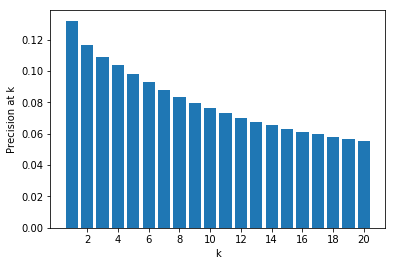

In [70]:
plt.figure()
plt.bar(np.arange(1,21),patk_by_k)
plt.xticks(np.arange(2,21,2))
plt.xlabel('k')
plt.ylabel('Precision at k')
plt.show()

10


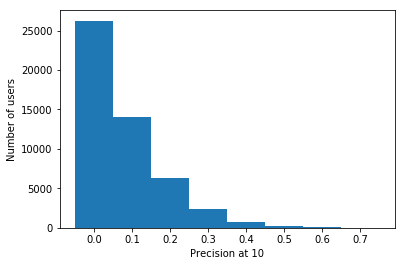

0.07612800000000002


0.10040581465233975

In [42]:
sample_k = 10
print(sample_k)
patk_all, mean_patk = precision_at_k(sample_k)
plt.hist(patk_all,bins=np.arange(-0.05,0.85,0.1))
plt.xlabel('Precision at 10')
plt.ylabel('Number of users')
plt.show()
print(mean_patk)
np.std(patk_all)

### What about just recommending the most popular 20 items over and over?


In [2]:
# re-create rec_list df with top 20 items by frequency.
top200products = pd.read_csv('top200_products.csv')
top200products.drop(['Unnamed: 0'],axis=1,inplace=True)
top20products = top200products.head(20)
top20products

,product_id,frequency,product_name,organic
0,24852,18726,Banana,0
1,13176,15480,Bag of Organic Bananas,1
2,21137,10894,Organic Strawberries,1
3,21903,9784,Organic Baby Spinach,1
4,47626,8135,Large Lemon,0
5,47766,7409,Organic Avocado,1
6,47209,7293,Organic Hass Avocado,1
7,16797,6494,Strawberries,0
8,26209,6033,Limes,0
9,27966,5546,Organic Raspberries,1


In [27]:
# get unique user_ids to filter order_products__train:
rec_list = pd.read_csv('top20_products_recom.csv')
unique_user_ids = rec_list['user_id'].unique()

Ordered products for User 1:  [196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]


,order_id,product_id,add_to_cart_order,reordered,user_id
484420,1187899,196,1,1,1
484421,1187899,25133,2,1,1
484422,1187899,38928,3,1,1
484423,1187899,26405,4,1,1
484424,1187899,39657,5,1,1
484425,1187899,10258,6,1,1
484426,1187899,13032,7,1,1
484427,1187899,26088,8,1,1
484428,1187899,27845,9,0,1
484429,1187899,49235,10,1,1


In [21]:
%%time

# Create dataframe equivalent to rec_list except it's the most popular items for each user.
rec_user = top20products[['product_id','product_name','organic']]
rec_user['freq_rank'] = np.arange(1,21)
rec_user['rec_rank'] = np.arange(1,21)

# use pd.concat and np.repeat rather than .append over and over.
rec_list_onlypopular = pd.concat([rec_user]*50000, ignore_index=True)
rec_list_onlypopular['user_id'] = np.repeat(unique_user_ids,20)

display(rec_list_onlypopular.head(25))
display(len(rec_list_onlypopular))

,product_id,product_name,organic,freq_rank,rec_rank,user_id
0,24852,Banana,0,1,1,1
1,13176,Bag of Organic Bananas,1,2,2,1
2,21137,Organic Strawberries,1,3,3,1
3,21903,Organic Baby Spinach,1,4,4,1
4,47626,Large Lemon,0,5,5,1
5,47766,Organic Avocado,1,6,6,1
6,47209,Organic Hass Avocado,1,7,7,1
7,16797,Strawberries,0,8,8,1
8,26209,Limes,0,9,9,1
9,27966,Organic Raspberries,1,10,10,1


1000000

CPU times: user 13.5 s, sys: 298 ms, total: 13.8 s
Wall time: 14.1 s


In [30]:
%%time

# Map function rec_prod_ordered (defined above) function over all recommended items (slow, but we only need once).

# Test function on one row first:
display(rec_list_onlypopular.iloc[0])
display(prods_dict[1])
display(rec_prod_ordered(rec_list_onlypopular.iloc[0])) # User 1 didn't buy Organic bananas, so returned false as expected.

# Map function over all recommended items:
rec_list_onlypopular['actually_in_user_order'] = rec_list_onlypopular.apply(rec_prod_ordered,axis=1)
display(rec_list_onlypopular)
# Then can calculate precision_at_k using groupby and taking top k.

product_id       24852
product_name    Banana
organic              0
freq_rank            1
rec_rank             1
user_id              1
Name: 0, dtype: object

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

False

,product_id,product_name,organic,freq_rank,rec_rank,user_id,actually_in_user_order
0,24852,Banana,0,1,1,1,False
1,13176,Bag of Organic Bananas,1,2,2,1,False
2,21137,Organic Strawberries,1,3,3,1,False
3,21903,Organic Baby Spinach,1,4,4,1,False
4,47626,Large Lemon,0,5,5,1,False
...,...,...,...,...,...,...,...
999995,24964,Organic Garlic,1,16,16,78707,False
999996,4920,Seedless Red Grapes,0,17,17,78707,False
999997,46979,Asparagus,0,18,18,78707,False
999998,40706,Organic Grape Tomatoes,1,19,19,78707,False


CPU times: user 23.2 s, sys: 334 ms, total: 23.5 s
Wall time: 23.7 s


In [31]:
#only 5% of top 20 popular items actually purchased by users
rec_list_onlypopular['actually_in_user_order'].value_counts(normalize=True) 

False    0.946827
True     0.053173
Name: actually_in_user_order, dtype: float64

In [32]:
# export so don't have to do it again.
rec_list_onlypopular.to_csv('top20_popular_products_recom_validation.csv')

In [33]:
# if re-running this notebook, load the DF from CSV
rec_list_onlypopular = pd.read_csv('top20_popular_products_recom_validation.csv')
rec_list_onlypopular.drop(['Unnamed: 0'],axis=1,inplace=True)

In [35]:
# Calculating precision at k for multiple ks
def precision_at_k_popular(k):
    all_hits = rec_list_onlypopular.loc[
        rec_list_onlypopular['rec_rank']<=k][['user_id','actually_in_user_order']].groupby('user_id').sum()
    all_patks = all_hits.values/k
    return all_patks, all_patks.mean()

patk_by_k = []
for sample_k in np.arange(1,21):
    patk_all, mean_patk = precision_at_k_popular(sample_k)
    patk_by_k.append(mean_patk)
    
print(patk_by_k)

[0.14446, 0.13083, 0.11528666666666666, 0.105375, 0.09669200000000001, 0.08986666666666668, 0.08510857142857141, 0.0805775, 0.07674888888888888, 0.07338, 0.07013272727272726, 0.06734166666666666, 0.06494153846153847, 0.0627742857142857, 0.06081733333333333, 0.059015, 0.057332941176470587, 0.05581333333333334, 0.05443894736842105, 0.053173000000000005]


10


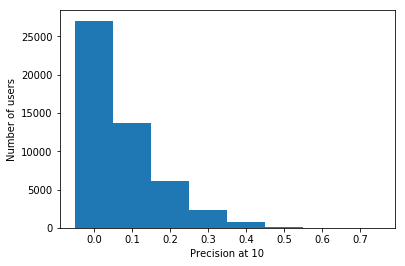

0.07338


0.09888465806180452

In [39]:
sample_k = 10
print(sample_k)
patk_all, mean_patk = precision_at_k_popular(sample_k)
plt.hist(patk_all,bins=np.arange(-0.05,0.85,0.1))
plt.xlabel('Precision at 10')
plt.ylabel('Number of users')
plt.show()
print(mean_patk)
np.std(patk_all)

In [36]:
print([0.132, 0.11651, 0.10897333333333332, 0.10374, 0.098012, 0.09274666666666666, 0.0877342857142857, 0.0836275, 0.07964222222222223, 0.07612800000000002, 0.07304, 0.07014666666666665, 0.06764, 0.0653042857142857, 0.06316533333333332, 0.061245, 0.05958705882352942, 0.05799333333333334, 0.05659684210526315, 0.055251])

[0.132, 0.11651, 0.10897333333333332, 0.10374, 0.098012, 0.09274666666666666, 0.0877342857142857, 0.0836275, 0.07964222222222223, 0.07612800000000002, 0.07304, 0.07014666666666665, 0.06764, 0.0653042857142857, 0.06316533333333332, 0.061245, 0.05958705882352942, 0.05799333333333334, 0.05659684210526315, 0.055251]
